# Sensitivity Analysis

We can reduce a network by doing a sensitivity analysis.  This removes each nucleus (one at a time) and measures the error introduced by the removal.  If the error is acceptable, then the nucleus is discarded.  Overall this is an $\mathcal{O}(N^2)$
operation, where $N$ is the number of nuclei.  For that reason, it's best to start off with a reasonably sized network.

Here we'll do the DRGEP reduction and then run the sensitivity analysis on that.

In [1]:
import pynucastro as pyna

We'll consider both the ReacLib rates and tabulated weak rates

In [2]:
all_lib = (pyna.ReacLibLibrary() +
           pyna.TabularLibrary(ordering=["ffn", "langanke", "oda"]))

To make the example more manageable, we'll use a low endpoint, ${}^{32}\mathrm{S}$,
and setup a {py:obj}`RateFilter <pynucastro.rates.library.RateFilter>`.

In [3]:
filt = pyna.RateFilter(endpoint="s32")
lib = all_lib.filter(filt)

and remove the duplicates, favoring tabulated weak rates.

In [4]:
dupes = lib.find_duplicate_links()
rates_to_remove = []
for d in dupes:
    for r in d:
        if isinstance(r, pyna.rates.ReacLibRate):
            rates_to_remove.append(r)

for r in rates_to_remove:
    lib.remove_rate(r)

Finally, we'll create our initial network.  We can use any type, so we'll just use
a {py:obj}`RateCollection <pynucastro.networks.rate_collection.RateCollection>`.

In [5]:
net = pyna.RateCollection(libraries=[lib])

We will use the energy generation rate as our metric for the sensitivity analysis.

```{warning}
Some of these nuclei do not have measured masses, which means we cannot use them
to create the energy release.
```

We will remove those nuclei without measured masses.

In [6]:
nuclei_to_remove = []
for n in net.unique_nuclei:
    if n.mass == None:
        nuclei_to_remove.append(n)

net.remove_nuclei(nuclei_to_remove)

looking to remove O29 ⟶ F29 + e⁻ + 𝜈
looking to remove O29 ⟶ n + F28 + e⁻ + 𝜈
looking to remove O29 ⟶ n + n + F27 + e⁻ + 𝜈
looking to remove O29 + He4 ⟶ n + Ne32
looking to remove O29 + He4 ⟶ p + F32
looking to remove F32 + p ⟶ He4 + O29
looking to remove Ne32 + n ⟶ He4 + O29
looking to remove O30 ⟶ F30 + e⁻ + 𝜈
looking to remove O30 ⟶ n + F29 + e⁻ + 𝜈
looking to remove O30 ⟶ n + n + F28 + e⁻ + 𝜈
looking to remove O31 ⟶ F31 + e⁻ + 𝜈
looking to remove O31 ⟶ n + F30 + e⁻ + 𝜈
looking to remove O31 ⟶ n + n + F29 + e⁻ + 𝜈
looking to remove O32 ⟶ F32 + e⁻ + 𝜈
looking to remove O32 ⟶ n + F31 + e⁻ + 𝜈
looking to remove O32 ⟶ n + n + F30 + e⁻ + 𝜈
looking to remove O32 ⟶ F32 + e⁻ + 𝜈
looking to remove F32 ⟶ Ne32 + e⁻ + 𝜈
looking to remove F32 ⟶ n + Ne31 + e⁻ + 𝜈
looking to remove F32 ⟶ n + n + Ne30 + e⁻ + 𝜈
looking to remove O29 + He4 ⟶ p + F32
looking to remove F32 + p ⟶ n + Ne32
looking to remove F32 + p ⟶ He4 + O29
looking to remove Ne32 + n ⟶ p + F32
looking to remove F32 ⟶ 3 n + Ne29 + e⁻ +

Here's our initial network

In [7]:
net.summary()

Network summary
---------------
  explicitly carried nuclei: 182
  approximated-out nuclei: 0
  inert nuclei (included in carried): 0

  total number of rates: 1731

  rates explicitly connecting nuclei: 1731
  hidden rates: 0

  reaclib rates: 1621
  tabular rates: 110
  approximate rates: 0
  derived rates: 0
  modified rates: 0
  custom rates: 0


## Thermodynamic conditions

Next we need to create a set of thermodynamic states to use to evaluate the energy generation.

```{warning}
Some of the nuclei are incredibly shortlived, and if we have any abundance there, it will dominate the rate evaluation.
```

When we initialize the {py:obj}`Composition <pynucastro.networks.rate_collection.Composition>`, we'll use the `half_life_thresh` option to zero out the abundance of any species that should immediately decay.

In [8]:
comp = pyna.Composition(net.unique_nuclei)
comp.set_solar_like(half_life_thresh=1.e-10)
comp.X[pyna.Nucleus("o14")] = 0.02
comp.X[pyna.Nucleus("o15")] = 0.01
comp.normalize()

Now our data to evaluate with.  We'll use the same composition everywhere.

In [9]:
data = [(comp, 1.e4, 1.e8),
        (comp, 1.e5, 2.e8),
        (comp, 1.e5, 1.e9),
        (comp, 5.e5, 2.e9)]

## First reduction: DRGEP

For DRGEP, we need to supply targets

In [10]:
targets = ["p", "he4",
           "n13", "n14", "n15",
           "c12", "c13",
           "o14", "o15", "o16", "o17", "o18",
           "f18", "f19",
           "ne18", "ne19", "ne20",
           "na22", "na23",
           "mg24", "si28", "s32"]

Now we'll do the DRGEP analysis

In [11]:
reduced_net = pyna.drgep(net=net, conds=data, targets=targets, tols=0.9)

/home/zingale/development/pynucastro/pynucastro/reduction/drgep_module.py:72: RuntimeWarning: invalid value encountered in divide
  r_AB = np.abs(p_AB - c_AB) / denom


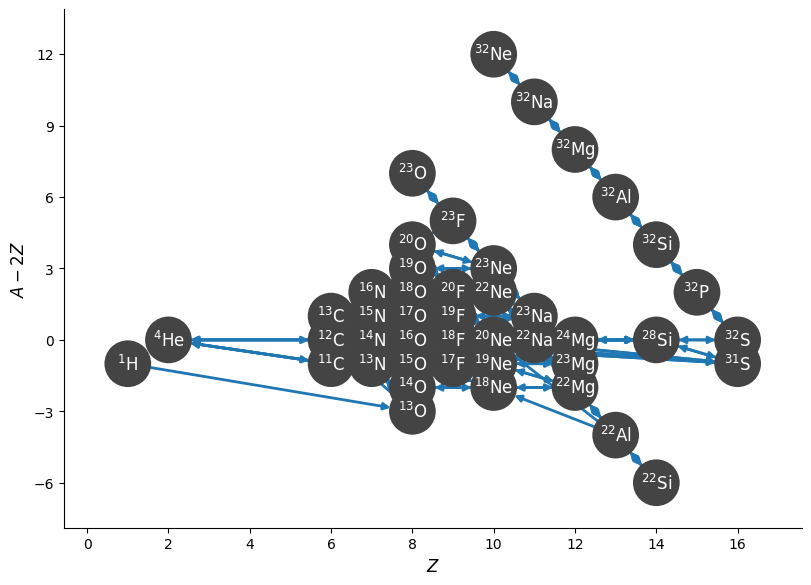

In [12]:
fig = reduced_net.plot(rotated=True, hide_xalpha=True, hide_xp=True)

In [13]:
reduced_net.summary()

Network summary
---------------
  explicitly carried nuclei: 45
  approximated-out nuclei: 0
  inert nuclei (included in carried): 0

  total number of rates: 290

  rates explicitly connecting nuclei: 290
  hidden rates: 0

  reaclib rates: 260
  tabular rates: 30
  approximate rates: 0
  derived rates: 0
  modified rates: 0
  custom rates: 0


## Sensitivity analysis

For the sensitivity analysis, we'll use the energy generation rate as our metric.  We need to supply an error function that takes a reduced net as the first argument.  We are free to append any additional arguments (that will be passed-through using the `args=` mechanism later).  Here we pass the data used to validate the network and a list of energy generation rate values pre-computed using the existing, large network.

In [14]:
def err_func(net, validation_data, enuc_reference):
    max_err = 0.0
    for n, (comp, rho, T) in enumerate(validation_data):
        enuc = net.evaluate_energy_generation(rho, T, comp)
        err = max(max_err, abs((enuc - enuc_reference[n]) / enuc_reference[n]))
    return err

We also need to set the threshold for removing a nucleus---this is the relative error that is acceptable.

In [15]:
threshold = 0.025

Next we precompute the reference values of energy generation rate.  This will be compared to the values we get as we remove a nucleus by our error function.

In [16]:
enuc_reference = []
for comp, rho, T in data:
    enuc_reference.append(reduced_net.evaluate_energy_generation(rho, T, comp))

Finally, we perform the sensitivity analysis.  We pass in our error function and also the additional arguments that get appended to the net via `args=`

In [17]:
reduced_net2 = pyna.sens_analysis(reduced_net, err_func,
                                  thresh=threshold, args=(data, enuc_reference))

Performing sensitivity analysis...
Pass 1: [⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙] 100%
Pass 2: [⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙] 100%
Pass 3: [⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙] 100%
Pass 4: [⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙] 100%
Pass 5: [⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙] 100%
Pass 6: [⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙] 100%
Pass 7: [⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙] 100%
Pass 8: [⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙] 100%
Pass 9: [⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙] 100%
Pass 10: [⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙] 100%
Pass 11: [⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙] 100%
Pass 12: [⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙] 100%
Pass 13: [⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙] 100%
Pass 14: [⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙] 100%
Pass 15: [⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙

In [20]:
reduced_net2.summary()

Network summary
---------------
  explicitly carried nuclei: 30
  approximated-out nuclei: 0
  inert nuclei (included in carried): 0

  total number of rates: 139

  rates explicitly connecting nuclei: 139
  hidden rates: 0

  reaclib rates: 127
  tabular rates: 12
  approximate rates: 0
  derived rates: 0
  modified rates: 0
  custom rates: 0


We've further reduced the network from 45 nuclei (after DRGEP) to 30.

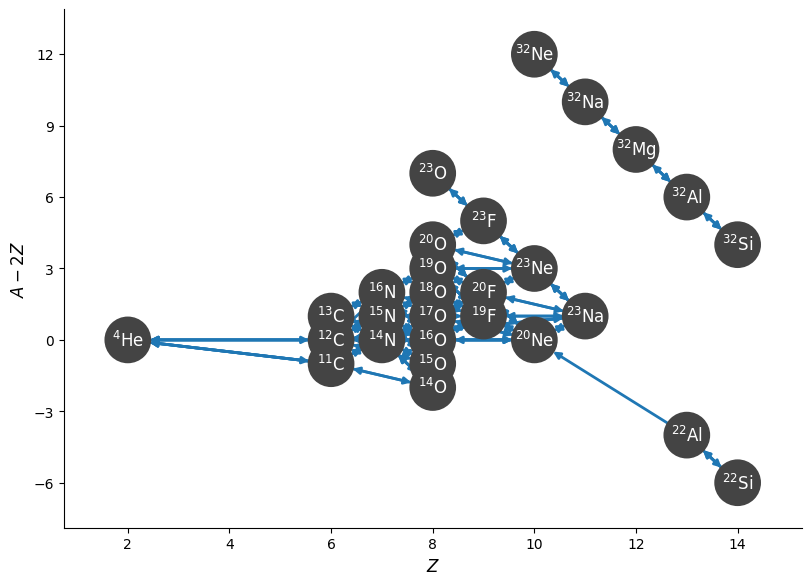

In [19]:
fig = reduced_net2.plot(rotated=True, hide_xalpha=True)

We see that there is a disjoint sequence of nuclei here.  The choice of conditions and threshold make this reduction very sensitive, so some experimentation is usually needed.